In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import models, transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import argparse

import os

In [2]:
device = torch.device("cpu")
model = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [3]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [4]:
# 마지막 2048 feature 들어있는 model.fc layer 에 hook 설정
activation = {}
model.avgpool.register_forward_hook(get_activation('avgpool'))

In [5]:
# input 이미지와 target 이미지 설정
input_image_list = [os.path.join("livingroom_data", cur_data) for cur_data in os.listdir("livingroom_data") if ".jpg" in cur_data]
target_image_list = [os.path.join("art_data", cur_data) for cur_data in os.listdir("art_data") if ".jpg" in cur_data]

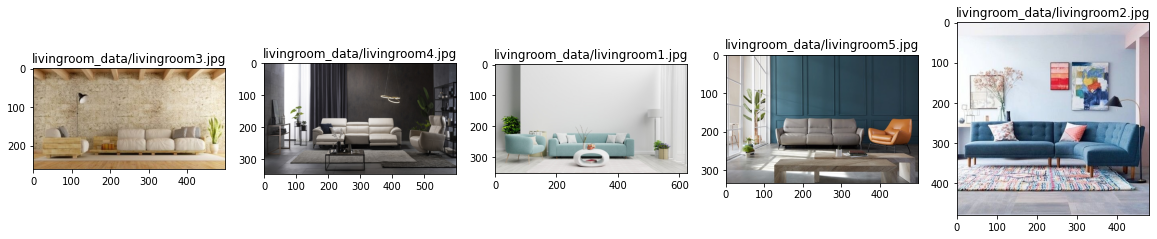

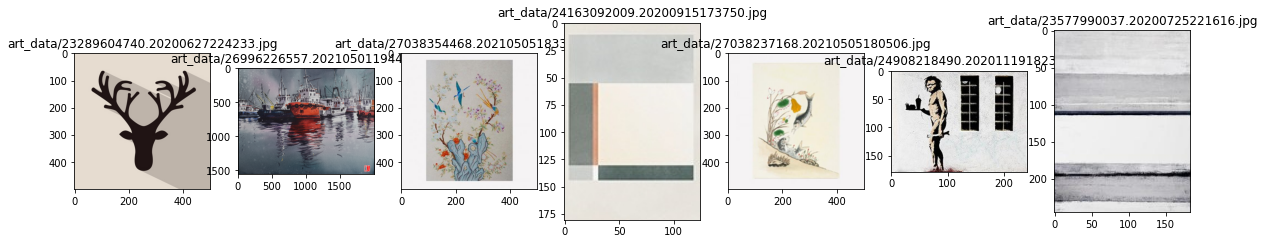

In [6]:
# read and visualize inputimages
plt.figure(figsize=(20, 4))
input_loaded_list = []
for i, input_image in enumerate(input_image_list):
    img = cv.imread(input_image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    input_loaded_list.append(img)
    if i < 5:
        plt.subplot(1,5, i+1).set_title(input_image)
        plt.imshow(img)
    
plt.show()
# read and visualize target images

target_loaded_list = []
plt.figure(figsize=(20, 5))
for i, input_image in enumerate(target_image_list):
    img = cv.imread(input_image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    if i<7:
      plt.subplot(1,7, i+1).set_title(input_image)
      plt.imshow(img)

    target_loaded_list.append(img)
plt.show()

In [7]:
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

input_transformed_list = []
target_transformed_list = []
loaded_list = [input_loaded_list, target_loaded_list]

for i, loaded in enumerate(loaded_list):
    for cur_loaded in loaded:
        img = np.array(cur_loaded)
        # apply the transforms
        img = transform(img)
        # unsqueeze to add a batch dimension
        img = img.unsqueeze(0)
        if i == 0:
            input_transformed_list.append(img)
        else:
            target_transformed_list.append(img)
print(f"Length input_transformed_list : {len(input_transformed_list)}, length target_transformed_list : {len(target_transformed_list)}")
print(f"Final shape : {input_transformed_list[0].shape}")

Length input_transformed_list : 5, length target_transformed_list : 266
Final shape : torch.Size([1, 3, 512, 512])


In [8]:
# pass the image through all the layers
input_results_list = []
target_results_list = []
transformed_list = [input_transformed_list, target_transformed_list]
layer_list = []

for i, transformed in enumerate(transformed_list):
    for cur_transformed in transformed:
        model(cur_transformed)       
                
        if i == 0:
            input_results_list.append(torch.squeeze(activation['avgpool']).numpy())
        else:
            target_results_list.append(torch.squeeze(activation['avgpool']).numpy())

print(f"num of input images : {len(input_results_list)}, shape of feature maps : {len(input_results_list[0])}")
print(f"num of target images : {len(target_results_list)}, shape of feature maps : {len(target_results_list[0])}")

num of input images : 5, shape of feature maps : 2048
num of target images : 266, shape of feature maps : 2048


In [9]:
from sklearn.decomposition import PCA

In [10]:
target_features = np.array(target_results_list)
pca = PCA(n_components=100)
pca.fit(target_features)

PCA(n_components=100)

In [11]:
target_pca = pca.transform(target_features)
input_pca = pca.transform(np.array(input_results_list))
print(f"target_pca shape : {target_pca.shape}")
print(f"input_pca shape : {input_pca.shape}")

target_pca shape : (266, 100)
input_pca shape : (5, 100)


In [12]:
from scipy.spatial import distance

In [13]:
similarity_list = []
idx_closest = []
for cur_input in input_pca:
    cur_sim_list = [distance.cosine(cur_target, cur_input) for cur_target in target_pca]
    similarity_list.append(cur_sim_list)
    idx_closest.append(sorted(range(len(cur_sim_list)), key=lambda k: cur_sim_list[k])[:4])

print(np.array(similarity_list).shape)
print(np.array(idx_closest).shape)

(5, 266)
(5, 4)


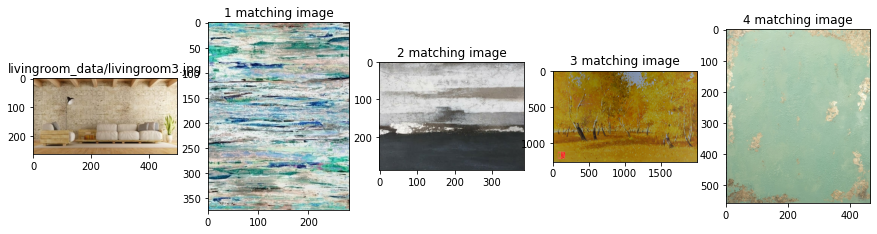

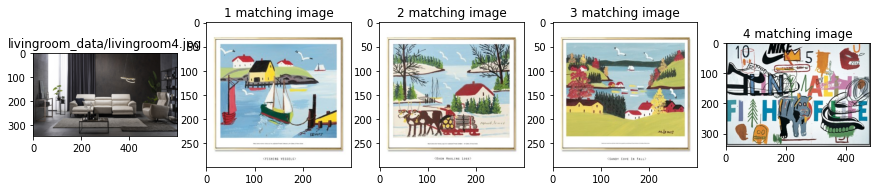

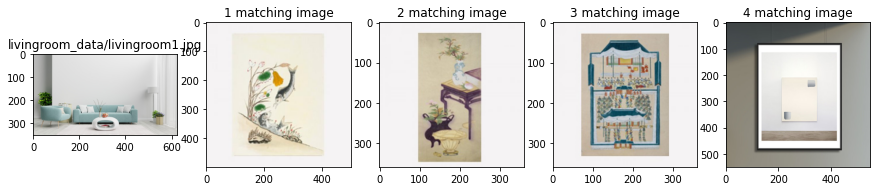

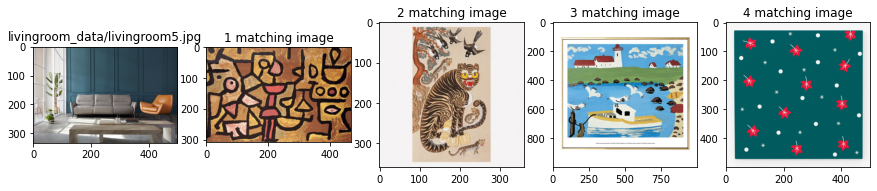

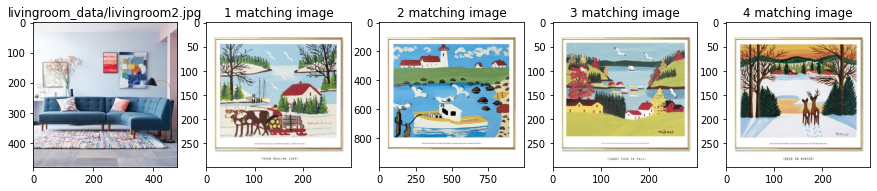

In [14]:
# compare layer by layer and choose the most similar image
count = 1
for i, cur_input in enumerate(input_results_list):
    plt.figure(figsize=(15,20))
    plt.subplot(len(input_results_list),5, count).set_title(input_image_list[i])
    plt.imshow(input_loaded_list[i])
    count += 1
    for j, cur_idx in enumerate(idx_closest[i]):
        plt.subplot(len(input_results_list),5, count).set_title(f'{j + 1} matching image')
        plt.imshow(target_loaded_list[cur_idx])
        if count < len(input_results_list)*5:
            count += 1
plt.show()

In [15]:
def get_resized_and_normalized_hist(input_loaded, target_loaded_list):
    input_loaded = cv.resize(input_loaded, dsize=(512, 512), interpolation=cv.INTER_AREA)
    input_hist = cv.calcHist([input_loaded], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    input_hist = cv.normalize(input_hist, input_hist).flatten()

    target_hist_list = []
    for i, target_loaded in enumerate(target_loaded_list):
        target_loaded_list[i] = cv.resize(target_loaded_list[i], dsize=(512, 512), interpolation=cv.INTER_AREA)
        target_hist = cv.calcHist([target_loaded_list[i]], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        target_hist = cv.normalize(target_hist, target_hist).flatten()
        target_hist_list.append(target_hist)

    return input_hist, target_hist_list

In [16]:
# OPENCV_METHODS = (
#  ("Correlation", cv2.HISTCMP_CORREL),
#  ("Chi-Squared", cv2.HISTCMP_CHISQR),
#  ("Intersection", cv2.HISTCMP_INTERSECT),
#  ("Hellinger", cv2.HISTCMP_BHATTACHARYYA))

def calc_origin_similarity(input_loaded, target_loaded_list):
    similarity = []
    input_hist, target_hist_list = get_resized_and_normalized_hist(input_loaded, target_loaded_list)

    for i, hist in enumerate(target_hist_list):
        # compute the distance between the two histograms
        # using the method and update the results dictionary
        d = cv.compareHist(input_hist, hist, cv.HISTCMP_CORREL)
        similarity.append(d)
    
    return similarity


In [17]:
def min_max_normalize(lst):
    normalized = []
    
    for value in lst:
        normalized_num = (value - min(lst)) / (max(lst) - min(lst))
        normalized.append(normalized_num)
    
    return normalized

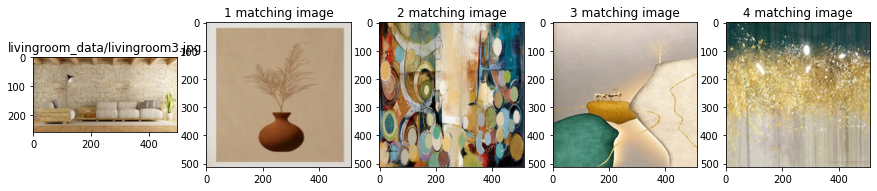

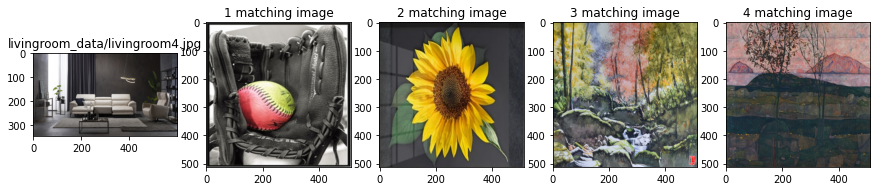

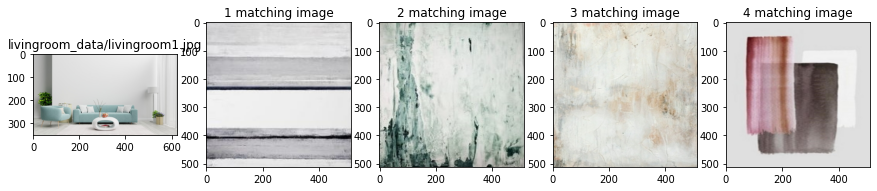

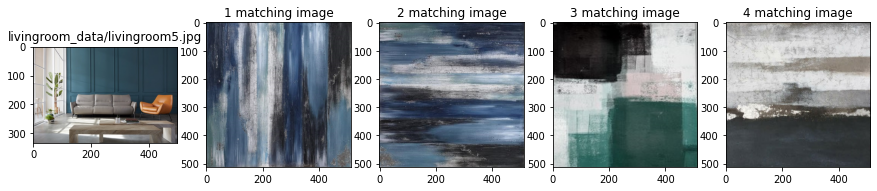

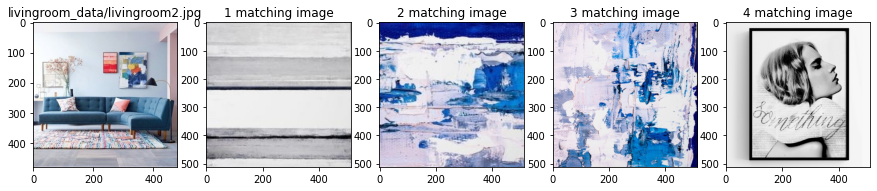

In [20]:
# compare layer by layer and choose the most similar image
count = 1
for i, cur_input in enumerate(input_results_list):
    plt.figure(figsize=(15,20))
    plt.subplot(len(input_results_list),5, count).set_title(input_image_list[i])
    plt.imshow(input_loaded_list[i])
    count += 1
    pca_similarity_list = similarity_list[i]
    norm_pca_similarity_list = min_max_normalize(pca_similarity_list)
    
    # 현재 input 의 original 이미지와 target 의 original 이미지에서 calhist 를 한다.
    origin_similarity_list = calc_origin_similarity(input_loaded_list[i], target_loaded_list)
#     print(f"color matching : {origin_similarity_list}")
    norm_color_similarity_list = min_max_normalize(origin_similarity_list)
#     norm_color_similarity_list = origin_similarity_list
     
    pattern_weight = 0
    color_weight = 1
    final_similarity_list = pattern_weight * np.array(norm_pca_similarity_list) + color_weight * np.array(norm_color_similarity_list)
    num_largest_index = -4
    index_list_of_similar_image_from_target = sorted(range(len(final_similarity_list)), key=lambda x: final_similarity_list[x])[num_largest_index:]
    
    for j, cur_index in enumerate(index_list_of_similar_image_from_target[::-1]):
        plt.subplot(len(input_results_list),5, count).set_title(f'{j + 1} matching image')
        plt.imshow(target_loaded_list[cur_index])
        if count < len(input_results_list)*5:
            count += 1
plt.show()

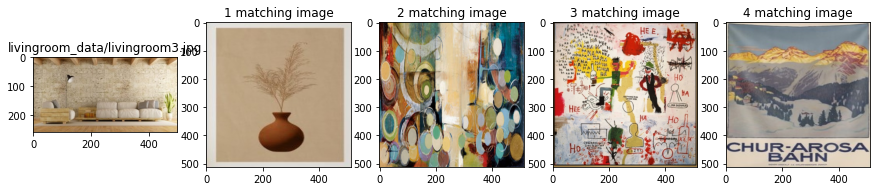

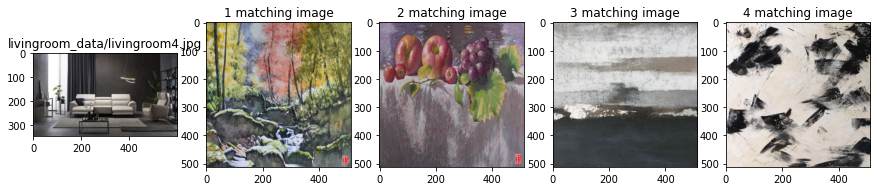

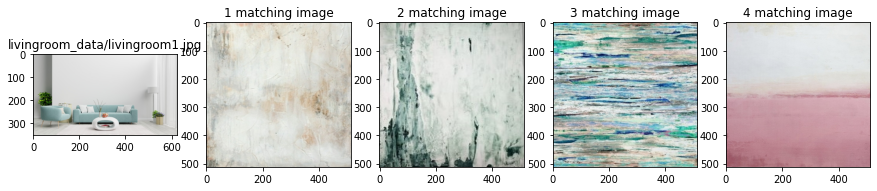

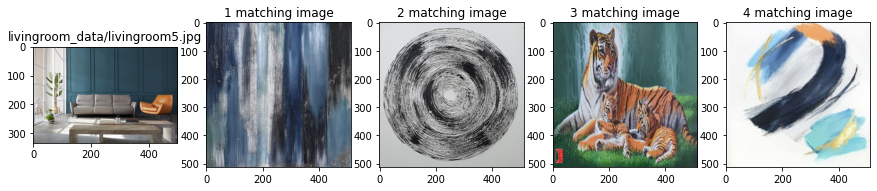

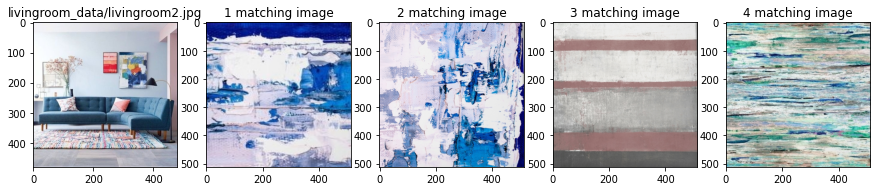

In [21]:
# compare layer by layer and choose the most similar image
count = 1
for i, cur_input in enumerate(input_results_list):
    plt.figure(figsize=(15,20))
    plt.subplot(len(input_results_list),5, count).set_title(input_image_list[i])
    plt.imshow(input_loaded_list[i])
    count += 1
    pca_similarity_list = similarity_list[i]
    norm_pca_similarity_list = min_max_normalize(pca_similarity_list)
    
    # 현재 input 의 original 이미지와 target 의 original 이미지에서 calhist 를 한다.
    origin_similarity_list = calc_origin_similarity(input_loaded_list[i], target_loaded_list)
#     print(f"color matching : {origin_similarity_list}")
    norm_color_similarity_list = min_max_normalize(origin_similarity_list)
#     norm_color_similarity_list = origin_similarity_list
     
    pattern_weight = 1
    color_weight = 1
    final_similarity_list = pattern_weight * np.array(norm_pca_similarity_list) + color_weight * np.array(norm_color_similarity_list)
    num_largest_index = -4
    index_list_of_similar_image_from_target = sorted(range(len(final_similarity_list)), key=lambda x: final_similarity_list[x])[num_largest_index:]
    
    for j, cur_index in enumerate(index_list_of_similar_image_from_target[::-1]):
        plt.subplot(len(input_results_list),5, count).set_title(f'{j + 1} matching image')
        plt.imshow(target_loaded_list[cur_index])
        if count < len(input_results_list)*5:
            count += 1
plt.show()

# 새 섹션